##Auto encoding


In [43]:
!pip install visualkeras
from Tumor_Classifier_Utils import *

def eval_model(model, x_test, y_test, history):
    predictions, decoded_imgs = model.predict(x_test);

    indexes = tf.argmax(predictions, axis=1)
    gt = tf.argmax(y_test, axis=1)
    
    cm = confusion_matrix(gt, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    print(classification_report(gt, indexes))
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.plot(history.history['autoenc_output_loss'], label = 'Auto-Encoder Loss')
    ax.plot(history.history['class_output_loss'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.plot(history.history['val_autoenc_output_loss'], label = 'Auto-Encoder Loss')
    ax.plot(history.history['val_class_output_loss'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Validation Loss')
    

In [44]:
data_train = scio.loadmat('/content/tumor_train_data_32.mat')
data_val = scio.loadmat('/content/tumor_val_data_32.mat')
data_test = scio.loadmat('/content/tumor_test_data_32.mat')
# print(data_train['img_train'].shape)
# print(data_train['labels_train'].shape)
# print(data_val['img_val'].shape)
# print(data_val['labels_val'].shape)
# print(data_test['img_test'].shape)
# print(data_test['labels_test'].shape)

N = 32 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

x_train = data_train['img_train'].astype('float32') / 255.
x_test = data_test['img_test'].astype('float32') / 255.
x_val = data_val['img_val'].astype('float32') / 255.

y_train = numpy.array(data_train['labels_train'])
y_test = numpy.array(data_test['labels_test'])
y_val = numpy.array(data_val['labels_val'])


x_train = numpy.reshape(data_train['img_train'], (data_train['img_train'].shape[2], 32, 32, 1))
x_test = numpy.reshape(data_test['img_test'], (data_test['img_test'].shape[2], 32, 32, 1))
x_val = numpy.reshape(data_val['img_val'], (data_val['img_val'].shape[2], 32, 32, 1))

# y_train = keras.utils.to_categorical(data_train['labels_train'])
# y_test =  keras.utils.to_categorical(data_test['labels_test'])
# y_val =  keras.utils.to_categorical(data_val['labels_val'])


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


(2500, 32, 32, 1)
(264, 32, 32, 1)
(500, 32, 32, 1)
(2500, 1)
(264, 1)
(500, 1)


In [45]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


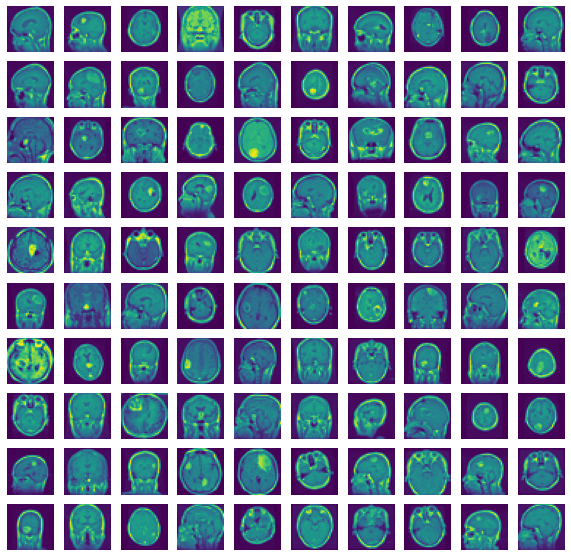

In [46]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

In [47]:

input_img = layers.Input(shape=(32, 32, 1))
# encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)

# compressed representation
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
# at this point the representation is (4, 4, 4) i.e. 64-dimensional

class_output = layers.Flatten()(encoded)
#class_output = Dense(64, activation='relu')(class_output)
class_output = layers.Dense(38, activation=None, name='classificaton_output')(class_output)

# decoder
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(encoded)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='autoencoder_output')(x)

autoEncoder = keras.Model(input_img, {'ae': decoded, 'class' : class_output})

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 16)   160         ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 16)  0           ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_25 (Conv2D)             (None, 16, 16, 8)    1160        ['max_pooling2d_8[0][0]']        
                                                                                            

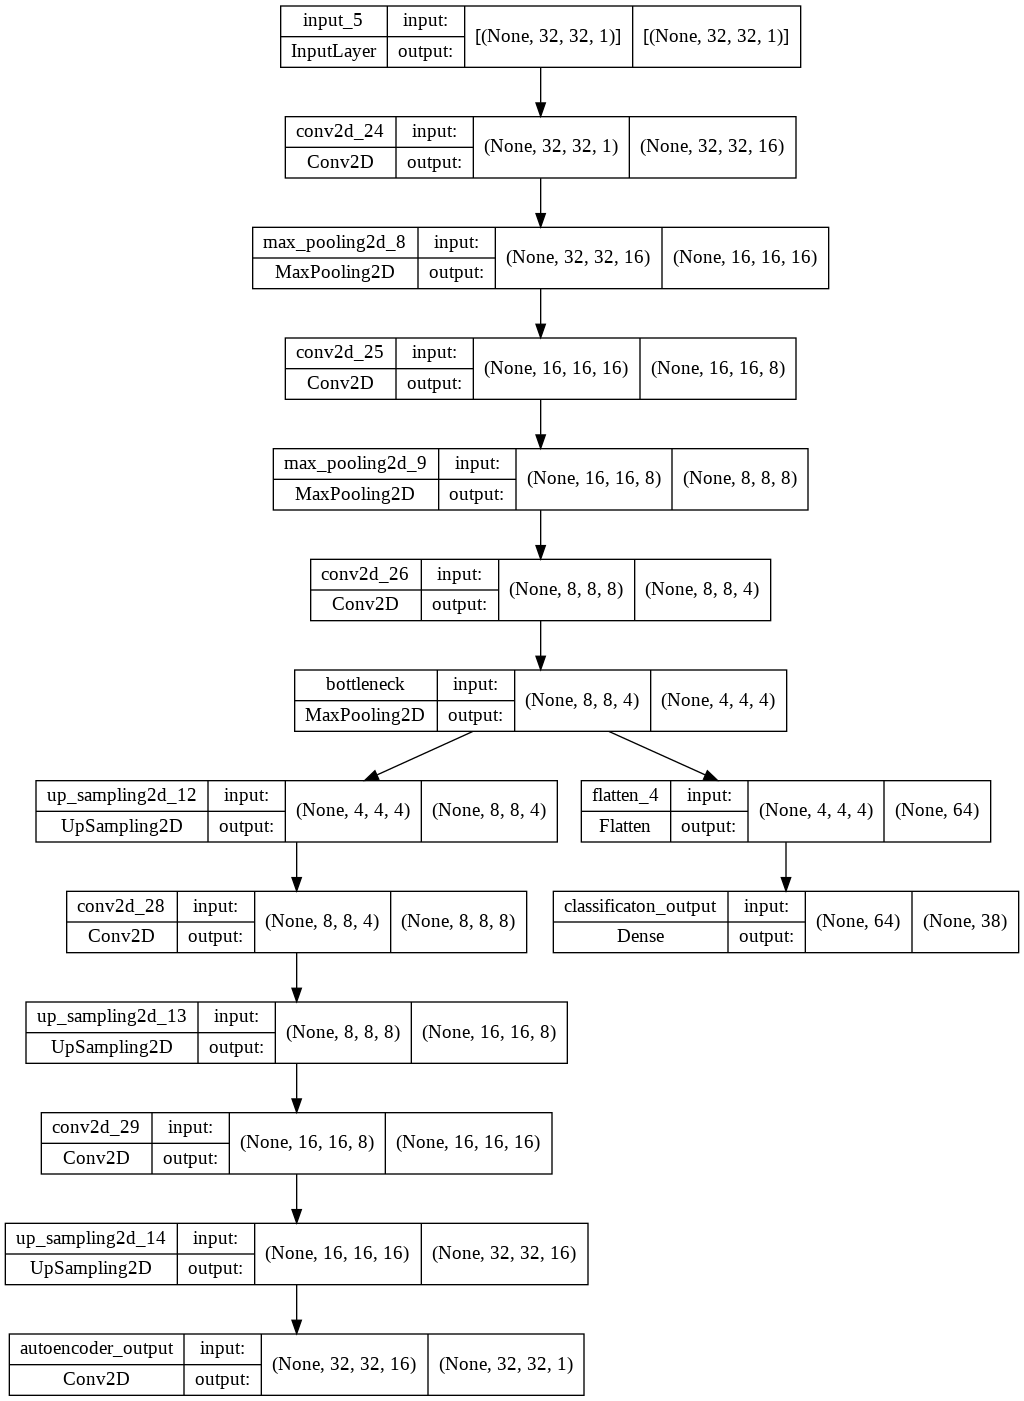

In [48]:
autoEncoder.compile(optimizer='adam', loss={'ae' : 'mean_squared_error', 'class' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)})
print(autoEncoder.summary())
keras.utils.plot_model(autoEncoder, show_shapes=True)

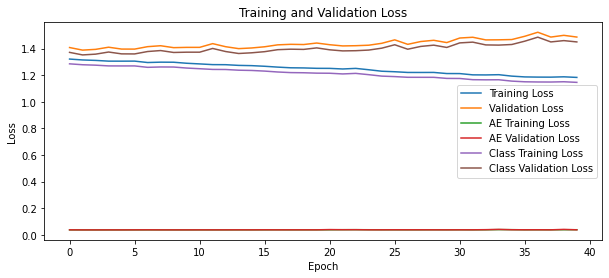

In [52]:
history = autoEncoder.fit(x_train, {'ae' : x_train, 'class' : y_train},
                    batch_size=128,
                    epochs=40,
                    validation_data=(x_val, {'ae' : x_val, 'class' : y_val} ), verbose = False)
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['autoencoder_output_loss'], label='AE Training Loss')
    plt.plot(history['val_autoencoder_output_loss'], label='AE Validation Loss')
    plt.plot(history['classificaton_output_loss'], label='Class Training Loss')
    plt.plot(history['val_classificaton_output_loss'], label='Class Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history.history)

In [49]:
   
decoded_imgs = autoEncoder.predict(test_fea_reshape)['ae']

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_fea_reshape[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()